In [1]:
dataset_name = "rds_cpu_utilization_cc0c53"
path = "data/" + dataset_name + ".csv"
gaussian_window_size = 1024

In [2]:
import adclasses
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import numpy as np
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


# Preprocess Dataset

In [3]:
data = pd.read_csv(path, header=0)
start_date = data["timestamp"].values[0]
end_date = data["timestamp"].values[-1]
print("Start date: ", start_date)
print("End date: ", end_date)
data["timestamp"] = pd.to_datetime(data["timestamp"], format="%Y-%m-%d %H:%M:%S")

print("Missing time stamps: \n", adclasses.find_missing_time_steps(start_date, end_date, '5min', data))

data["timestamp"] = pd.to_datetime(data["timestamp"], format="%Y-%m-%d %H:%M:%S")
ad = adclasses.UnivariateAnomalyDetection(dataframe=data, timestep="5min", dateformat="%Y-%m-%d %H:%M:%S", name=dataset_name)
print("Length: ", ad.get_length())
print("Time step size: ", ad.get_timestep())
print("Date Format: ", ad.get_dateformat())
true_outlier_dates = ["2014-02-25 07:15:00",
                      "2014-02-27 00:50:00"]
true_outlier_indices = ad.convert_true_outlier_date(true_outlier_dates)
print("True outlier indices: ", true_outlier_indices)

Start date:  2014-02-14 14:30:00
End date:  2014-02-28 14:30:00
Missing time stamps: 
 DatetimeIndex(['2014-02-25 07:10:00'], dtype='datetime64[ns]', freq='5T')
Length:  4033
Time step size:  5min
Date Format:  %Y-%m-%d %H:%M:%S
True outlier indices:  [3081, 3580]


# SARIMA


 Fitting models using approximations to speed things up...

 ARIMA(2,0,2) with non-zero mean : Inf
 ARIMA(0,0,0) with non-zero mean : 486.8655
 ARIMA(1,0,0) with non-zero mean : 486.2647
 ARIMA(0,0,1) with non-zero mean : 485.8397
 ARIMA(0,0,0) with zero mean     : 487.1006
 ARIMA(1,0,1) with non-zero mean : Inf
 ARIMA(0,0,2) with non-zero mean : 487.9974
 ARIMA(1,0,2) with non-zero mean : Inf
 ARIMA(0,0,1) with zero mean     : 485.9503

 Now re-fitting the best model(s) without approximations...

 ARIMA(0,0,1) with non-zero mean : 485.8436

 Best model: Regression with ARIMA(0,0,1) errors 



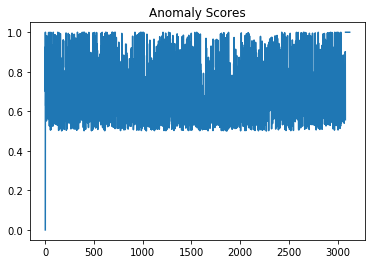

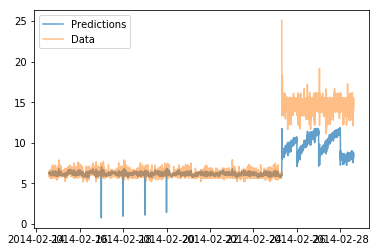

Time:  10.866907358169556


['anomaly_scores/SARIMA_auto/rds_cpu_utilization_cc0c53_no_fill']

In [4]:
save_path = "anomaly_scores/SARIMA_auto/" + dataset_name+ "_no_fill"
output_dict = ad.sarimax(gaussian_window_size=gaussian_window_size, step_size=100, auto=True,
                         use_exog=True, plot_anomaly_scores=True,plot_forecast=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# Prophet

In [5]:
# optimization step

step_sizes = [100, 200]
changepoint_prior_scales = [.01, .05, .1, .15, .2]
opt_dict = {}

for step_size in step_sizes:
    for changepoint_prior_scale in changepoint_prior_scales:

        mse = ad.facebook_prophet(gaussian_window_size=gaussian_window_size, 
                                  changepoint_prior_scale=changepoint_prior_scale,
                                  step_size=step_size,
                                  optimize=True)
        print("Step Size: ", step_size)
        print("Changepoint Prior Scale: ", changepoint_prior_scale)
        print("MSE: ",mse)

        key_str = "Step Size " + str(step_size) +" Changepoint Prior Scale" + str(changepoint_prior_scale)

        opt_dict[key_str] = mse

best_params = min(opt_dict, key=opt_dict.get)
print("\nbest params: ", best_params)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Changepoint Prior Scale:  0.01
MSE:  0.20925961932309087


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Changepoint Prior Scale:  0.05
MSE:  0.13744155536811142


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Changepoint Prior Scale:  0.1
MSE:  0.12577880743313377


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Changepoint Prior Scale:  0.15
MSE:  0.1252570998148385


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Changepoint Prior Scale:  0.2
MSE:  0.12379253661253613


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Changepoint Prior Scale:  0.01
MSE:  0.20925961932309087


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Changepoint Prior Scale:  0.05
MSE:  0.13744155536811142


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Changepoint Prior Scale:  0.1
MSE:  0.12577880743313377


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Changepoint Prior Scale:  0.15
MSE:  0.1252570998148385
Step Size:  200
Changepoint Prior Scale:  0.2
MSE:  0.12379253661253613

best params:  Step Size 100 Changepoint Prior Scale0.2


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


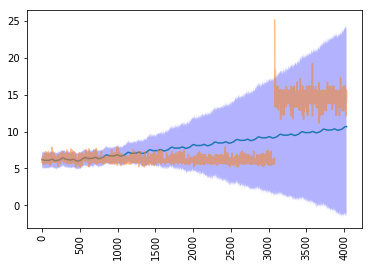

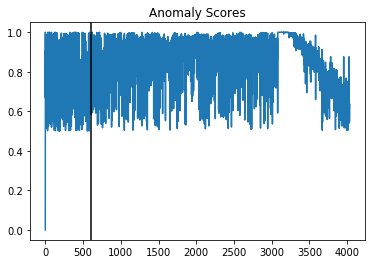

Time:  27.96406650543213


['anomaly_scores/Prophet/rds_cpu_utilization_cc0c53_no_fill']

In [6]:
save_path = "anomaly_scores/Prophet/" + dataset_name+ "_no_fill"
output_dict = ad.facebook_prophet(gaussian_window_size=gaussian_window_size, 
                                  changepoint_prior_scale=.2,
                                  step_size=100,
                                  plot_forecast=True,
                                  plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# GLM

In [7]:
# optimize
etas = [.5,1]
lambdas = [.99, .999, .9999]

opt_dict = {}

for eta in etas:
    for lambda_ in lambdas:
       
        mse = ad.glm(gaussian_window_size=gaussian_window_size, 
                     family='gaussian', 
                     eta=eta, 
                     lambda_=lambda_)["MSE"]

        print("eta: ", eta)
        print("lambda: ", lambda_)
        print("MSE: ",mse)

        key_str = "eta " + str(eta) + " lambda " + str(lambda_)

        opt_dict[key_str] = mse

best_params = min(opt_dict, key=opt_dict.get)
print("\nbest params: ", best_params)

 41%|████▏     | 1668/4032 [00:00<00:00, 16673.14it/s]

Initial Mean 6.191179917218543
Initial StdDev 0.36675138143331315


 31%|███       | 1234/4032 [00:00<00:00, 12332.19it/s]

eta:  0.5
lambda:  0.99
MSE:  8.812711240901121e+19
Initial Mean 6.191179917218543
Initial StdDev 0.36675138143331315


 43%|████▎     | 1745/4032 [00:00<00:00, 17445.32it/s]

eta:  0.5
lambda:  0.999
MSE:  6.721819264814894
Initial Mean 6.191179917218543
Initial StdDev 0.36675138143331315


 46%|████▌     | 1863/4032 [00:00<00:00, 18627.04it/s]

eta:  0.5
lambda:  0.9999
MSE:  12.347476164779762
Initial Mean 6.191179917218543
Initial StdDev 0.36675138143331315


 45%|████▍     | 1798/4032 [00:00<00:00, 17976.16it/s]

eta:  1
lambda:  0.99
MSE:  4218748.657283111
Initial Mean 6.191179917218543
Initial StdDev 0.36675138143331315


 37%|███▋      | 1489/4032 [00:00<00:00, 14883.56it/s]

eta:  1
lambda:  0.999
MSE:  3.630254238680535
Initial Mean 6.191179917218543
Initial StdDev 0.36675138143331315


100%|██████████| 4032/4032 [00:00<00:00, 14011.93it/s]


eta:  1
lambda:  0.9999
MSE:  9.247047591580928

best params:  eta 1 lambda 0.999


 40%|████      | 1626/4032 [00:00<00:00, 16253.08it/s]

Initial Mean 6.191179917218543
Initial StdDev 0.36675138143331315


100%|██████████| 4032/4032 [00:00<00:00, 16691.49it/s]


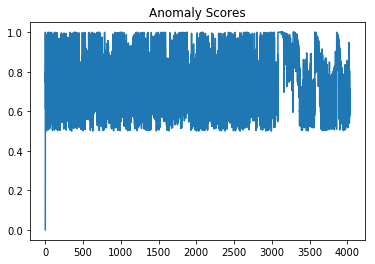

Time:  1.2011387348175049


['anomaly_scores/GLM/rds_cpu_utilization_cc0c53_no_fill']

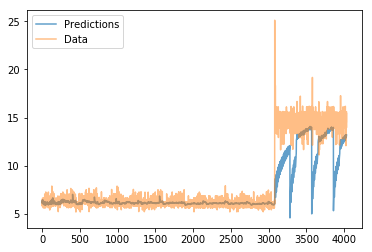

In [8]:
save_path = "anomaly_scores/GLM/" + dataset_name+ "_no_fill"
output_dict = ad.glm(gaussian_window_size=gaussian_window_size, family='gaussian', 
                     eta=1, lambda_=0.999,plot_anomaly_scores=True, plot_forecast=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

In [9]:
# no seasonality so no stl